<a href="https://colab.research.google.com/github/BrandonChiazza/captone/blob/main/Text_only_classifier_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text only classification of Hateful Memes using pre-trained BERT algorithm.

The datasource comes from pre-processing steps performed on open source dataset from this paper (https://gombru.github.io/2019/10/09/MMHS/).

Code is located at:  
https://github.com/yeshivadataanalytics/hate-classification/blob/HS_Hate_Speech_Image/Pre-processing/Pre-processing%20Capstone.ipynb

The output of this pre-processing step (and input of this notebook) is a json file (new_json.json) with the following structure:

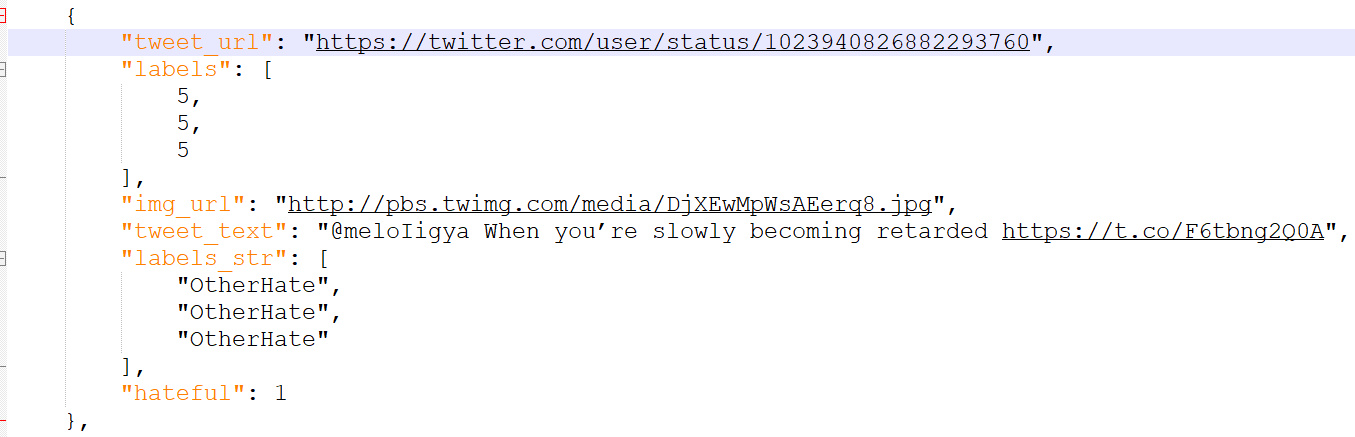

## Steps

- Load json file from S3 bucket (there are around 13000 records with the text from the meme image extracted and the label for hateful)
- Load and use __transformers__ which is pytorch interface for BERT pre-trained algorithm.


Image below is extracted from Facebook paper (https://arxiv.org/pdf/1909.02950.pdf), where they used Bert as a text-only baseline to compare to text+image tasks. 

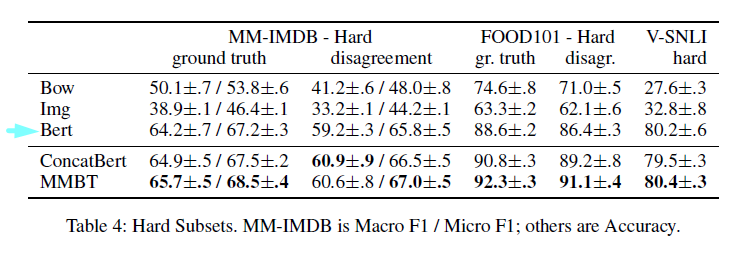

Guide that followed to implement it: <br> 
- https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1 <br>

Another implementations
- https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b
- https://towardsdatascience.com/identifying-hate-speech-with-bert-and-cnn-b7aa2cddd60d
 
To understand BERT in more detail: <br>
- https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a 
- https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
<br>
- http://jalammar.github.io/illustrated-bert/
  - https://jalammar.github.io/illustrated-transformer/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Installing requirements ##
!pip install transformers # (Installs pytorch interface for BERT)

from transformers import BertTokenizer
import torch
from sklearn.model_selection import train_test_split
import string
import re
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 1.3MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 21.2MB/s 
     |████████████████████████████████| 890kB 55.3MB/s 
     |████████████████████████████████| 1.1MB 50.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=6b0ee55b2cb78216394dd97dffe233bd4e89c7d10e05cede1ded584ea89ef6f9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# If there's a GPU available, tell PyTorch to use the GPU, otherwise use CPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# loading json files from google drive
!unzip -qq '/content/drive/My Drive/Fall 2020/Capstone/Capstone Shared/Text/textdata'

In [ ]:
file = open('/content/textdata.json')
df = pd.read_json(file)
df.head(2)

,id,img,text,source,old_id,label,split
0,11758,,Find me at,opensourcepaper,1056228733487603712,0,training
1,7582,,10:00 PMET DOES THIS OFFEND YOU?,opensourcepaper,1050722238360514560,1,training


## **Data Preprocessing**
The text feature in the train and test sets are noisy . One way to clean the feature is by removing:
- URLs
- html content

In [ ]:
#Clean the text
def remove_URL(text):
    url = re.compile(r'http\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_user(text):
    user = re.compile(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)')
    return re.sub(user, '', text)

# Applying helper functions
df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_user(x))
df.head(4)

,id,img,text,source,old_id,label,split,text_clean
0,11758,,Find me at,opensourcepaper,1056228733487603712,0,training,Find me at
1,7582,,10:00 PMET DOES THIS OFFEND YOU?,opensourcepaper,1050722238360514560,1,training,1000 PMET DOES THIS OFFEND YOU
2,6780,,I don't like messy queens. Idon't like cheap q...,opensourcepaper,1047330454024552448,1,training,I dont like messy queens Idont like cheap quee...
3,11414,,ⓒMUFC,opensourcepaper,1055944923286044672,0,training,MUFC


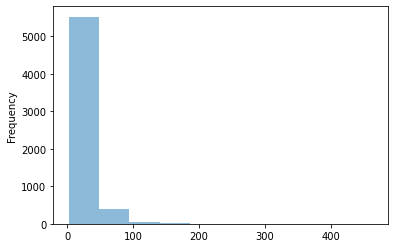

In [ ]:
# get word counts
df['word_count'] = df.text_clean.map(lambda text_clean: len(text_clean.split(" ")))
df['word_count'].plot.hist(alpha=0.5)

In [ ]:
# exclude below 200 words
df = df[df.word_count<50]

In [ ]:
# getting indexes to use later on data loaders
df = df.reset_index()
training_index = df[df.split == 'training'].index.values
validation_index = df[df.split == 'validation'].index.values
testing_index = df[df.split == 'testing'].index.values

In [ ]:
# Get the lists of sentences and their labels (of the training set) as numpy arrays
# training
sentences = df.text_clean.values
labels = df.label.values #  (0=not-hateful, 1=hateful).

In [ ]:
#Tokenization & Input Formatting - Load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


To see the code for Tokenization <br>
https://github.com/google-research/bert/blob/master/tokenization.py <br>

As we saw in the quicktour, the tokenizer will first split a given text in words (or part of words, punctuation symbols, etc.) usually called tokens. Then it will convert those tokens into numbers, to be able to build a tensor out of them and feed them to the model. It will also add any additional inputs the model might expect to work properly. <br>
https://huggingface.co/transformers/preprocessing.html

### BERT has two constraints:
- All sentences must be padded or truncated to a single, fixed length.
- The maximum sentence length is 512 tokens.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
  sentence = sent #get only first 200 characters

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start and `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
  encoded_sent = tokenizer.encode(sentence, add_special_tokens = True,)
    
  # Add the encoded sentence to the list.
  input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

max = max([len(sen) for sen in input_ids])
print('Max sentence length training: ', max)

Original:  Find me at 
Token IDs: [101, 2424, 2033, 2012, 102]
Max sentence length training:  97


In [ ]:
# Padding and truncating
# Set the maximum sequence length and apply padding. 
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = max

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0. "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
print('\Done.')
print('Max sentence length: ', MAX_LEN)


Padding/truncating all sentences to 97 values...

Padding token: "[PAD]", ID: 0
\Done.
Max sentence length:  97


In [ ]:
# Create Attention Masks for each sentence
attention_masks = []
for sent in input_ids:
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype for our model. Slice based on the index for training, validation and testing
inputs_training = torch.tensor(input_ids[~training_index])
inputs_validation = torch.tensor(input_ids[~validation_index])
inputs_testing = torch.tensor(input_ids[~testing_index])

# labels
labels_training = torch.tensor(labels[~training_index])
labels_validation = torch.tensor(labels[~validation_index])
labels_testing = torch.tensor(labels[~testing_index])

# masks
attention_masks = np.array(attention_masks)
masks_training = torch.tensor(attention_masks[~training_index])
masks_validation = torch.tensor(attention_masks[~validation_index])
masks_testing = torch.tensor(attention_masks[~testing_index])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32
# Create the DataLoader for our training set.
training_data = TensorDataset(inputs_training, masks_training, labels_training)
training_sampler = RandomSampler(training_data)
training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(inputs_validation, masks_validation, labels_validation)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set.
testing_data = TensorDataset(inputs_testing, masks_testing, labels_testing)
testing_sampler = SequentialSampler(testing_data)
testing_dataloader = DataLoader(testing_data, sampler=testing_sampler, batch_size=batch_size)

In [ ]:
#iteration = next(iter(training_data))
#iteration

In [ ]:
#iteration[0].size()

## 4. Train Our Classification Model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification. The huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. We’ll be using __Bert Classification Model__.This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [ ]:
# Train Our Classification Model
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 6-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

In [ ]:
#!pip install pytorch_pretrained_bert

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch). I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                 eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10
# Total number of training steps is number of batches * number of epochs.
total_steps = len(training_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# function for formatting elapsed times.
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:

import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. The call to  `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(training_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(training_dataloader), elapsed))
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Clear gradients before performing a backward pass. PyTorch doesn't do this automatically because  accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch). This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        #`loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient. 
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(training_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of     86.    Elapsed: 0:00:20.
  Batch    80  of     86.    Elapsed: 0:00:40.

  Average training loss: 0.70
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.53
  Validation took: 0:00:06

======== Epoch 2 / 10 ========
Training...
  Batch    40  of     86.    Elapsed: 0:00:21.
  Batch    80  of     86.    Elapsed: 0:00:41.

  Average training loss: 0.67
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.54
  Validation took: 0:00:07

======== Epoch 3 / 10 ========
Training...
  Batch    40  of     86.    Elapsed: 0:00:21.
  Batch    80  of     86.    Elapsed: 0:00:43.

  Average training loss: 0.62
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.51
  Validation took: 0:00:07

======== Epoch 4 / 10 ========
Training...
  Batch    40  of     86.    Elapsed: 0:00:22.
  Batch    80  of     86.    Elapsed: 0:00:44.

  Average training loss: 0.51
  Training epcoh took: 0:00:47

In [ ]:
#Let’s take a look at our training loss over all batches:
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

### 5. Performance On Test Set

## 5.2. Evaluate on Test Set

In [ ]:
# for metrics
y_pred = []
y_true = []

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(inputs_testing)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in testing_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  # collect metrics
  logits = outputs[0]
  y_pred.extend(torch.argmax(logits, 1).tolist())
  y_true.extend(b_labels.tolist())

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

Predicting labels for 1,658 test sentences...
DONE.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y_true, y_pred, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.53      0.57      0.55       884
           0       0.55      0.51      0.53       897

    accuracy                           0.54      1781
   macro avg       0.54      0.54      0.54      1781
weighted avg       0.54      0.54      0.54      1781



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y_true, y_pred, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.55      0.57      0.56       828
           0       0.55      0.53      0.54       830

    accuracy                           0.55      1658
   macro avg       0.55      0.55      0.55      1658
weighted avg       0.55      0.55      0.55      1658



[Text(0, 0.5, 'HATEFUL'), Text(0, 1.5, 'NOT HATEFUL')]

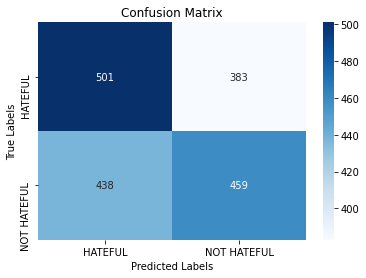

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['HATEFUL', 'NOT HATEFUL'])
ax.yaxis.set_ticklabels(['HATEFUL', 'NOT HATEFUL'])